# Lights 

> Defines a Light class for building light schedules and implements typical schedules used in circadian models

In [ ]:
#| default_exp lights

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *
from circadian.plots import Actogram 

In [ ]:
#| export 
import numpy as np
import pylab as plt
from typing import Optional
from matplotlib.pyplot import step
from fastcore.basics import patch_to
from numpy.core.fromnumeric import repeat

The `Light` class streamlines the process of creating light schedules for circadian models. Each Light object is created by defining three parameters: a `light` callable, `start_time`, and `duration`. These properties determine how and when the light is on. The `light` parameter can be a single value or a function returning nonnegative values. The schedule returns a `default_value` when called outside of the specified time range. Only nonnegative values are allowed for `light`, `start_time`, and `duration`.

In [ ]:
#| export
class Light:
    "Helper class for creating light schedules"
    def __init__(self, 
                 light: callable, # light function that takes in a time value and returns a float, if a float is passed, then the light function is a constant set to that lux value 
                 start_time: float=0.0, # when the light function starts in hours
                 duration: float=1.0, # duration of the light function in hours
                 default_value: float=0.0 # the default value of the light function outside of its duration
                 ):
        # light type checking
        light_input_err_msg = "`light` should be a nonnegative `float`, or a callable with a single `float` parameter which returns a nonnegative `float`"
        if callable(light):
            light_fn = np.vectorize(light, otypes=[float])
            output = light_fn(0.0)
            try:
                float(output)
            except:
                # catches when the function created from light does not return values that can be cast to float
                raise ValueError(light_input_err_msg)
        else:
            try:
                light = float(light)
                light_fn = np.vectorize(lambda t: light, otypes=[float])
            except:
                # catches when the light function can't be converted to a float
                raise ValueError(light_input_err_msg)

        # start_time type checking
        start_time_err_msg = "`start_time` should be a `float`"
        try:
            start_time = float(start_time)
        except:
            # catches when start_time can't be converted to a float
            raise ValueError(start_time_err_msg)

        # duration type checking
        duration_err_msg = "`duration` should be a nonnegative `float`"
        try:
            duration = float(duration)
            if duration < 0:
                raise ValueError(duration_err_msg)
        except:
            # catches when duration can't be converted to a float
            raise ValueError(duration_err_msg)

        # default_value type checking
        default_value_err_msg = "`default_value` should be a nonnegative `float`"
        try:
            default_value = float(default_value)
            if default_value < 0:
                raise ValueError(default_value_err_msg)
        except: 
            # catches when default_value can't be converted to a float
            raise ValueError(default_value_err_msg)

        # check that the light function returns nonnegative values
        if np.any(light_fn(np.linspace(start_time, start_time + duration, 100)) < 0):
            raise ValueError(light_input_err_msg)

        # assign attributes
        self._func = light_fn
        self.duration = duration
        self.start_time = start_time
        self.default_value = default_value

In [ ]:
#| hide
# Tests: Should be able to create a light function from callables and floats (or ints)
test_eq(Light(1.0)._func(0), 1.0)
test_eq(Light(1)._func(0), 1.0)
# Resulting function should be vectorized
test_eq(Light(1.0)._func(np.zeros(10)), np.ones(10))
light = lambda t: 10.0*t
fn = Light(light)._func
test_eq(fn(np.linspace(0.0, 1.0, 100)), 10.0*np.linspace(0.0, 1.0, 100))
light = lambda t: 1
fn = Light(light)._func
test_eq(fn(np.linspace(0.0, 1.0, 100)), np.ones(100))
# Light function should only return floats
light_input_err_msg = "`light` should be a `float`, or a callable with a single `float` parameter which returns `float`"
test_fail(lambda: Light('a'), msg=light_input_err_msg)
test_fail(lambda: Light([]), msg=light_input_err_msg)
test_fail(lambda: Light(lambda x: 'a'), msg=light_input_err_msg)
test_fail(lambda: Light(lambda x: []), msg=light_input_err_msg)
test_fail(lambda: Light(lambda x, y: 1.0), msg=light_input_err_msg)
# Light function should not return negative values
test_fail(lambda: Light(-1.0), msg=light_input_err_msg)
test_fail(lambda: Light(lambda t: -1.0), msg=light_input_err_msg)
test_fail(lambda: Light(lambda t: np.sin(t), duration=10.0), msg=light_input_err_msg) # returns negative lux values for certain t values

In [ ]:
#| hide
# Tests: Setting default_value, start_time, and duration
test_eq(Light(1.0, default_value=1.0).default_value, 1.0)
test_eq(Light(1.0, default_value=1).default_value, 1.0)
test_eq(Light(1.0, start_time=1.0).start_time, 1.0)
test_eq(Light(1.0, start_time=1).start_time, 1.0)
test_eq(Light(1.0, duration=1.0).duration, 1.0)
test_eq(Light(1.0, duration=1).duration, 1.0)
# Start time should be a float
start_time_err_msg = "`start_time` should be a `float`"
test_fail(lambda: Light(1.0, start_time='a'), msg=start_time_err_msg)
test_fail(lambda: Light(1.0, start_time=[]), msg=start_time_err_msg)
test_fail(lambda: Light(1.0, start_time=np.ones(2)), msg=start_time_err_msg)
# Duration should be a nonnegative float
duration_err_msg = "`duration` should be a nonnegative `float`"
test_fail(lambda: Light(1.0, duration='a'), msg=duration_err_msg)
test_fail(lambda: Light(1.0, duration=[]), msg=duration_err_msg)
test_fail(lambda: Light(1.0, duration=np.ones(2)), msg=duration_err_msg)
test_fail(lambda: Light(1.0, duration=-1.0), msg=duration_err_msg)
# Default value should be a nonnegative float
default_value_err_msg = "`default_value` should be a nonnegative `float`"
test_fail(lambda: Light(1.0, default_value='a'), msg=default_value_err_msg)
test_fail(lambda: Light(1.0, default_value=[]), msg=default_value_err_msg)
test_fail(lambda: Light(1.0, default_value=np.ones(2)), msg=default_value_err_msg)
test_fail(lambda: Light(1.0, default_value=-1.0), msg=default_value_err_msg)

In [ ]:
#| export
@patch_to(Light, as_prop=True)
def end_time(self: Light):
    "End time of the active portion of the light function"
    return self.start_time + self.duration

In [ ]:
#| hide
# Tests: Correct calculation of end_time
test_eq(Light(1.0, start_time=10.0, duration=2.0).end_time, 12.0)

In [ ]:
#| export
@patch_to(Light)
def __call__(self, 
             t: np.ndarray, # time values in hours to evaluate the light function
             repeat_period: float = None # should the light function repeat after a certain period in hours
             ):
    # t type checking
    t_err_msg = "`t` should be a `float` or a 1d `numpy.ndarray` of `float`"
    try:
        t = np.array(t, dtype=float)
        if t.ndim == 0:
            try:
                t = float(t)
                t = np.array([t])
            except:
                raise ValueError(t_err_msg)
        elif t.ndim != 1:
            raise ValueError(t_err_msg)
    except:
        raise ValueError(t_err_msg)
    # repeat_period type checking
    repeat_period_err_msg = "`repeat_period` should be a nonnegative `float`"
    if repeat_period is not None:
        try:
            repeat_period = float(repeat_period)
            if repeat_period < 0:
                raise ValueError(repeat_period_err_msg)
        except:
            raise ValueError(repeat_period_err_msg)
    
    if repeat_period is not None:
        t = np.mod(t, repeat_period)
    default_result = np.zeros_like(t)
    if self.duration == 0.0:
        return default_result + self.default_value
    else:
        mask = (t >= self.start_time) & (t <= self.end_time)
        default_result[~mask] = self.default_value
        func_result  = self._func(t[mask])
        default_result[mask] += func_result
        return default_result

In [ ]:
#| hide
time = np.linspace(0.0, 24.0, 100)
# Tests: Correct evaluation of light function
constant_light = Light(100.0, start_time=0.0, duration=24.0)
test_eq(constant_light(1) == 100.0, True)
test_eq(constant_light(1.0) == 100.0, True)
test_eq(np.all(constant_light([0, 1, 2, 3, 4]) == 100.0), True)
test_eq(np.all(constant_light(time) == 100.0), True)
# Default value should not be added to the active region
default_light = Light(100.0, start_time=12.0, duration=12.0, default_value=25.0)
test_eq(np.all(default_light(time[time < 12.0]) == 25.0), True)
test_eq(np.all(default_light(time[time >= 12.0]) == 100.0), True)
# Duration of 0 should result in a constant light function
zero_duration_light_zero_default = Light(100.0, start_time=12.0, duration=0.0)
test_eq(np.all(zero_duration_light_zero_default(time) == 0.0), True)
zero_duration_light_positive_default = Light(100.0, start_time=12.0, duration=0.0, default_value=25.0)
test_eq(np.all(zero_duration_light_positive_default(time) == 25.0), True)
# Pulse should be confined to the active region
pulse_light = Light(100.0, start_time=12.0, duration=2.0)
pre_pulse_mask = time < 12.0
pulse_mask = (time >= 12.0) & (time <= 14.0)
post_pulse_mask = time > 14.0
schedule = pulse_light(time)
test_eq(np.all(schedule[pre_pulse_mask]==0.0), True)
test_eq(np.all(schedule[pulse_mask]==100.0), True)
test_eq(np.all(schedule[post_pulse_mask]==0.0), True)
# Complex functions should be evaluated correctly
def repeat_values(t):
    if t > 6.0 and t < 7.0:
        return 100.0
    elif t > 18.0 and t < 19.0:
        return 200.0
    else:
        return 0.0
repeat_pulse = Light(repeat_values, start_time=0.0, duration=24.0)
pre_pulse_1_mask = time < 6.0
pulse_1_mask = (time >= 6.0) & (time <= 7.0)
between_pulses_mask = (time > 7.0) & (time < 18.0)
pulse_2_mask = (time >= 18.0) & (time <= 19.0)
post_pulses_mask = time > 19.0
schedule = repeat_pulse(time)
test_eq(np.all(schedule[pre_pulse_1_mask]==0.0), True)
test_eq(np.all(schedule[pulse_1_mask]==100.0), True)
test_eq(np.all(schedule[between_pulses_mask]==0.0), True)
test_eq(np.all(schedule[pulse_2_mask]==200.0), True)
test_eq(np.all(schedule[post_pulses_mask]==0.0), True)
# Repeat period should be respected
repeat_pulse = Light(100.0, start_time=6.0, duration=1.0)
schedule = repeat_pulse(time, repeat_period=12.0)
test_eq(np.all(schedule[pre_pulse_1_mask]==0.0), True)
test_eq(np.all(schedule[pulse_1_mask]==100.0), True)
test_eq(np.all(schedule[between_pulses_mask]==0.0), True)
test_eq(np.all(schedule[pulse_2_mask]==100.0), True)
test_eq(np.all(schedule[post_pulses_mask]==0.0), True)
# Parameter t should be something that can be converted to a numpy array
t_err_msg = "`t` should be a `float` or a `numpy.ndarray` of `float`"
test_fail(lambda: constant_light('a'), msg=t_err_msg)
test_fail(lambda: constant_light(np.ones((2,2))), msg=t_err_msg)
# Parameter repeat_period should be a nonnegative float
repeat_period_err_msg = "`repeat_period` should be a nonnegative `float`"
test_fail(lambda: constant_light(time, repeat_period='a'), msg=repeat_period_err_msg)
test_fail(lambda: constant_light(time, repeat_period=[]), msg=repeat_period_err_msg)
test_fail(lambda: constant_light(time, repeat_period=np.ones(2)), msg=repeat_period_err_msg)
test_fail(lambda: constant_light(time, repeat_period=-1.0), msg=repeat_period_err_msg)

For example, we can create a single pulse of light simply by

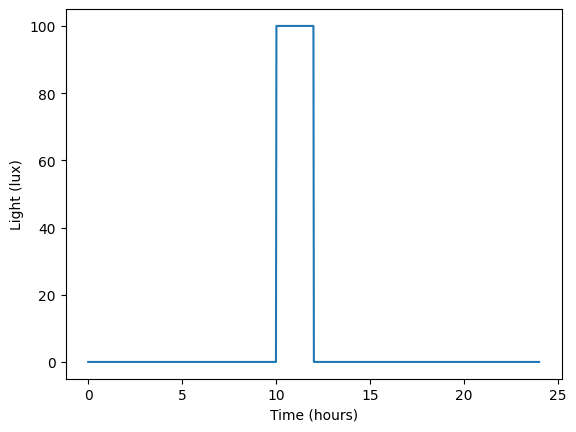

In [ ]:
schedule = Light(100.0, start_time=10.0, duration=2.0)
time = np.linspace(0.0, 24.0, 1000)
plt.plot(time, schedule(time));
plt.xlabel('Time (hours)');
plt.ylabel('Light (lux)');

or adjust the baseline with the `default_value` parameter

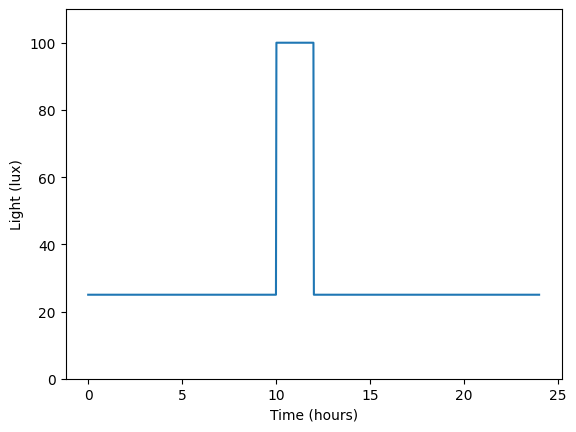

In [ ]:
schedule = Light(100.0, start_time=10.0, duration=2.0, default_value=25.0)
time = np.linspace(0.0, 24.0, 1000)
plt.plot(time, schedule(time));
plt.ylim(0, 110);
plt.xlabel('Time (hours)');
plt.ylabel('Light (lux)');

Additionally, we can create more complex light schedules by using a function for `light`. For example, we can create a light schedule that ramps up and down over a 12 hour period

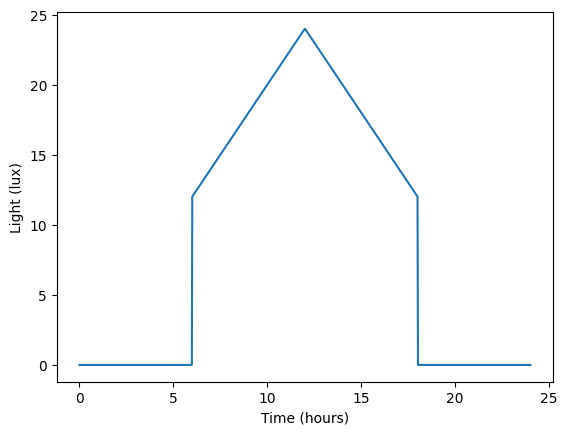

In [ ]:
def ramp(t):
    if t < 12.0:
        return 2.0*t
    else:
        return 2.0*(24.0 - t)

schedule = Light(ramp, start_time=6.0, duration=12.0)
time = np.linspace(0.0, 24.0, 1000)
plt.plot(time, schedule(time));
plt.xlabel('Time (hours)');
plt.ylabel('Light (lux)');

or a light schedule that oscillates over a 12 hour period

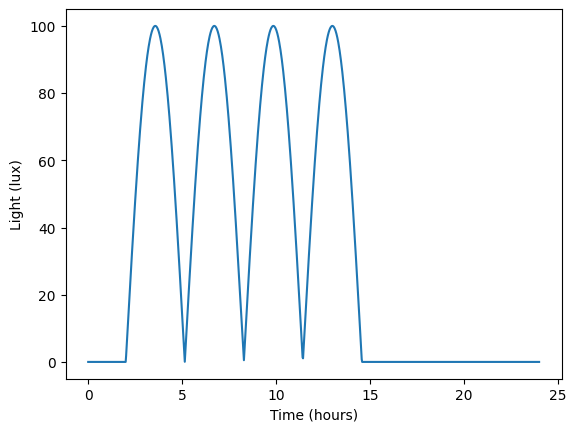

In [ ]:
def oscillate(t):
    return np.abs(100.0*np.sin(t-2.0))

schedule = Light(oscillate, start_time=2.0, duration=4*np.pi)
time = np.linspace(0.0, 24.0, 1000)
plt.plot(time, schedule(time));
plt.xlabel('Time (hours)');
plt.ylabel('Light (lux)');

For convenience, when evaluating our light schedule, we can specify a `repeat_period` value to repeat the light schedule over a specified period. For example, we can repeat the oscillating light schedule over a 24 hour period

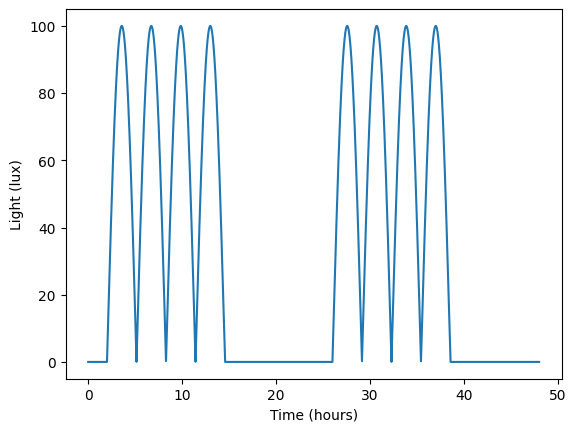

In [ ]:
schedule = Light(oscillate, start_time=2.0, duration=4*np.pi)
time = np.linspace(0.0, 48.0, 10000)
longer_periodic_schedule = schedule(time, repeat_period=24.0)
plt.plot(time, longer_periodic_schedule);
plt.xlabel('Time (hours)');
plt.ylabel('Light (lux)');

In [ ]:
#| export
@patch_to(Light)
def __add__(self, 
            light_obj: 'Light' # another light object to be added to the current light object
            ):
    start_times = [self.start_time, light_obj.start_time]
    end_times = [self.end_time, light_obj.end_time]
    default_values = [self.default_value, light_obj.default_value]
    light_functions = [self._func, light_obj._func]

    new_start_time = min(start_times)
    new_duration = max(end_times) - new_start_time
    new_default_value = sum(default_values)

    if self.duration == 0.0 and light_obj.duration != 0.0:
        new_start_time = light_obj.start_time
        new_duration = light_obj.duration
        def new_light_func(t):
            overlap_with_default = (t >= new_start_time) & (t <= new_start_time + new_duration)
            conditions = [overlap_with_default]
            values = [light_obj._func(t) + self.default_value]
            return np.piecewise(t, conditions, values)

    elif light_obj.duration == 0.0 and self.duration != 0.0:
        new_start_time = self.start_time
        new_duration = self.duration
        def new_light_func(t):
            overlap_with_default = (t >= new_start_time) & (t <= new_start_time + new_duration)
            conditions = [overlap_with_default]
            values = [self._func(t) + light_obj.default_value]
            return np.piecewise(t, conditions, values)

    elif light_obj.duration == 0.0 and self.duration == 0.0:
        new_start_time = 0.0
        new_duration = 0.0
        def new_light_func(t):
            return new_default_value

    else:
        if min(end_times) - max(start_times) <= 0:
            # light functions do not overlap
            def new_light_func(t):
                first_portion = (t >= min(start_times)) & (t <= min(end_times))
                default_zone = (t > min(end_times)) & (t < max(start_times))
                second_portion = (t >= max(start_times)) & (t <= max(end_times))
                conditions =  [first_portion, 
                            default_zone, 
                            second_portion]
                values = [light_functions[np.argmin(start_times)](t) + default_values[np.argmax(start_times)],
                        new_default_value, 
                        light_functions[np.argmax(start_times)](t) + default_values[np.argmin(start_times)]]

                return np.piecewise(t, conditions, values)
        else:
            # light functions overlap
            def new_light_func(t):
                first_no_overlap = (t >= min(start_times)) & (t < max(start_times))
                overlap = (t >= max(start_times)) & (t < min(end_times))
                second_no_overlap = (t >= min(end_times)) & (t <= max(end_times))
                conditions = [first_no_overlap, 
                            overlap, 
                            second_no_overlap]
                values = [light_functions[np.argmin(start_times)](t) + default_values[np.argmax(start_times)],
                        light_functions[0](t) + light_functions[1](t),
                        light_functions[np.argmax(start_times)](t) + default_values[np.argmin(start_times)]]

                return np.piecewise(t, conditions, values)

    return Light(new_light_func, start_time=new_start_time, duration=new_duration, default_value=new_default_value)

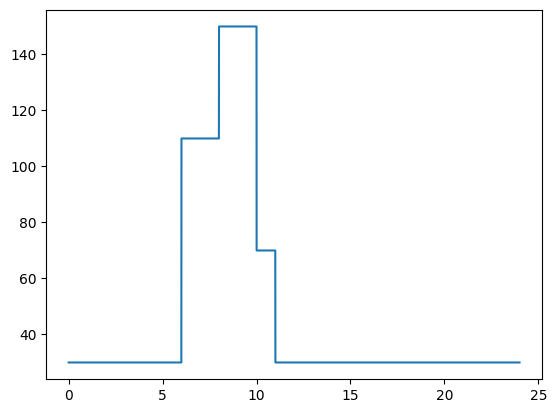

In [ ]:
l = Light(100.0, start_time=6.0, duration=4.0, default_value=20.0) + Light(50.0, start_time=8.0, duration=3.0, default_value=10.0)
time = np.linspace(0.0, 24.0, 10000)
plt.plot(time, l(time));

In [ ]:
#| hide
# Tests: Correct addition of light functions
time = np.linspace(0.0, 24.0, 10000)
# Non-overlapping light functions
l1 = Light(100.0, start_time=6.0, duration=2.0, default_value=10.0)
l2 = Light(50.0, start_time=12.0, duration=3.0, default_value=20.0)
l_sum = l1 + l2
test_eq(l_sum.start_time, 6.0)
test_eq(l_sum.duration, 9.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 15.0)
test_eq(np.all(l_sum(time[time < 6.0]) == 30.0), True) 
test_eq(np.all(l_sum(time[(time >= 6.0) & (time <= 8.0)]) == 120.0), True)
test_eq(np.all(l_sum(time[(time > 8.0) & (time < 12.0)]) == 30.0), True)
test_eq(np.all(l_sum(time[(time >= 12.0) & (time <= 15.0)]) == 60.0), True)
test_eq(np.all(l_sum(time[time > 15.0]) == 30.0), True)

l1 = Light(lambda t: 100.0*t, start_time=6.0, duration=2.0, default_value=10.0)
l2 = Light(lambda t: 50.0*t, start_time=12.0, duration=3.0, default_value=20.0)
l_sum = l1 + l2
test_eq(l_sum.start_time, 6.0)
test_eq(l_sum.duration, 9.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 15.0)
test_eq(np.all(l_sum(time[time < 6.0]) == 30.0), True)
first_portion = time[(time >= 6.0) & (time <= 8.0)]
test_eq(np.all(l_sum(first_portion) == 100.0*first_portion + 20.0), True)
no_overlap = time[(time > 8.0) & (time <= 12.0)]
test_eq(np.all(l_sum(no_overlap) == 30.0), True)
second_portion = time[(time > 12.0) & (time <= 15.0)]
test_eq(np.all(l_sum(second_portion) == 50.0*second_portion + 10.0), True)
test_eq(np.all(l_sum(time[time > 15.0]) == 30.0), True)

# Overlapping light functions
l1 = Light(100.0, start_time=6.0, duration=4.0, default_value=20.0)
l2 = Light(50.0, start_time=8.0, duration=3.0, default_value=10.0)
l_sum = l1 + l2
test_eq(l_sum.start_time, 6.0)
test_eq(l_sum.duration, 5.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 11.0)
test_eq(np.all(l_sum(time[time < 6.0]) == 30.0), True)
test_eq(np.all(l_sum(time[(time >= 6.0) & (time < 8.0)]) == 110.0), True)
test_eq(np.all(l_sum(time[(time >= 8.0) & (time < 10.0)]) == 150.0), True)
test_eq(np.all(l_sum(time[(time >= 10.0) & (time < 11.0)]) == 70.0), True)
test_eq(np.all(l_sum(time[time >= 11.0]) == 30.0), True)

l1 = Light(lambda t: 100.0*t, start_time=6.0, duration=4.0, default_value=20.0)
l2 = Light(lambda t: 50.0*t, start_time=8.0, duration=3.0, default_value=10.0)
l_sum = l1 + l2
test_eq(l_sum.start_time, 6.0)
test_eq(l_sum.duration, 5.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 11.0)
test_eq(np.all(l_sum(time[time < 6.0]) == 30.0), True)
first_portion = time[(time >= 6.0) & (time < 8.0)]
test_eq(np.all(l_sum(first_portion) == 100.0*first_portion + 10.0), True)
overlap = time[(time >= 8.0) & (time < 10.0)]
test_eq(np.all(l_sum(overlap) == 100.0*overlap + 50.0*overlap), True)
second_portion = time[(time >= 10.0) & (time < 11.0)]
test_eq(np.all(l_sum(second_portion) == 50.0*second_portion + 20.0), True)
test_eq(np.all(l_sum(time[time >= 11.0]) == 30.0), True)

# Summing duration 0 light functions
l1 = Light(100.0, start_time=6.0, duration=3.0, default_value=20.0)
l2 = Light(50.0, start_time=8.0, duration=0.0, default_value=10.0)
l_sum = l1 + l2
test_eq(l_sum.start_time, 6.0)
test_eq(l_sum.duration, 3.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 9.0)
test_eq(np.all(l_sum(time[time < 6.0]) == 30.0), True)
test_eq(np.all(l_sum(time[(time >= 6.0) & (time <= 9.0)]) == 110.0), True)
test_eq(np.all(l_sum(time[time > 9.0]) == 30.0), True)
# Reverse the order
l_sum = l2 + l1 
test_eq(l_sum.start_time, 6.0)
test_eq(l_sum.duration, 3.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 9.0)
test_eq(np.all(l_sum(time[time < 6.0]) == 30.0), True)
test_eq(np.all(l_sum(time[(time >= 6.0) & (time <= 9.0)]) == 110.0), True)
test_eq(np.all(l_sum(time[time > 9.0]) == 30.0), True)
# Sum two light functions with duration 0
l1 = Light(100.0, start_time=6.0, duration=0.0, default_value=20.0)
l2 = Light(50.0, start_time=8.0, duration=0.0, default_value=10.0)
l_sum = l1 + l2
test_eq(l_sum.start_time, 0.0)
test_eq(l_sum.duration, 0.0)
test_eq(l_sum.default_value, 30.0)
test_eq(l_sum.end_time, 0.0)
test_eq(np.all(l_sum(time) == 30.0), True)

In [ ]:
#| export
@patch_to(Light)
def concatenate(self, light_obj: 'Light'):
    "Concatenate two light functions in time"
    switch_time = self.end_time
    def light_func_new(t): return np.piecewise(t, [t <= switch_time, t >= switch_time],                                       [
        self._func, lambda t: light_obj._func(t-switch_time)])

    start_time_new = min(self.start_time, light_obj.start_time)
    duration_new = light_obj.duration + self.duration
    return Light(light_func_new, start_time=start_time_new, duration=duration_new)

In [ ]:
#| export
@patch_to(Light)
def plot(self, 
         plot_start_time: float = None, # start time of the plot in hours
         plot_end_time: float = None, # end time of the plot in hours
         repeat_period: float = None, # period of the plot in hours
         num_samples: int=10000, # number of samples to plot
         ax=None, # matplotlib axis to plot on
         *args, # arguments to pass to matplotlib.pyplot.plot
         **kwargs # keyword arguments to pass to matplotlib.pyplot.plot
         ):
    "Plot the light function between `start_time` and `end_time` with `num_samples` samples"
    # type checking
    if plot_start_time is not None:
        if not isinstance(plot_start_time, (float, int)):
            raise ValueError(f"plot_start_time must be a float or int, got {type(plot_start_time)}")
    if plot_end_time is not None:
        if not isinstance(plot_end_time, (float, int)):
            raise ValueError(f"plot_end_time must be a float or int, got {type(plot_end_time)}")
    if repeat_period is not None:
        if not isinstance(repeat_period, (float, int)):
            raise ValueError(f"repeat_period must be a float or int, got {type(repeat_period)}")
    if ax is not None:
        if not isinstance(ax, plt.Axes):
            raise ValueError(f"ax must be a matplotlib Axes object, got {type(ax)}")
    if num_samples is not None:
        if not isinstance(num_samples, int):
            raise ValueError(f"num_samples must be an int, got {type(num_samples)}")
    
    if plot_start_time is None:
        plot_start_time = self.start_time
    if plot_end_time is None:
        plot_end_time = self.end_time
        
    t = np.linspace(plot_start_time, plot_end_time, num_samples)
    vals = self.__call__(t, repeat_period=repeat_period)
    if ax is None:
        plt.figure()
        ax = plt.gca()

    ax.plot(t, vals, *args, **kwargs)
    return ax

In [ ]:
#| hide
# Tests: Plot type checking
schedule = Light(100.0, start_time=6.0, duration=3.0, default_value=20.0)
test_fail(lambda: l.plot(plot_start_time="a"), contains="plot_start_time must be a float or int")
test_fail(lambda: l.plot(plot_end_time="a"), contains="plot_end_time must be a float or int")
test_fail(lambda: l.plot(repeat_period="a"), contains="repeat_period must be a float or int")
test_fail(lambda: l.plot(num_samples="a"), contains="num_samples must be an int")
test_fail(lambda: l.plot(ax="a"), contains="ax must be a matplotlib Axes object")

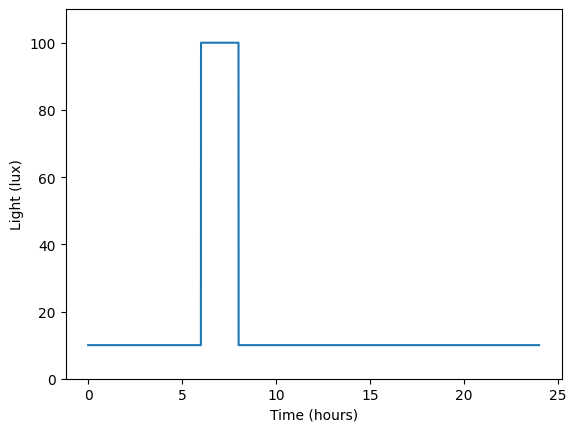

In [ ]:
#| hide
schedule = Light(100.0, start_time=6.0, duration=2.0, default_value=10.0)
ax = schedule.plot(0.0, 24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(0, 110);

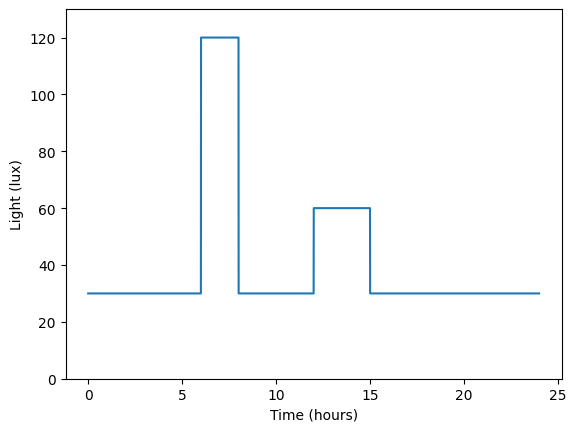

In [ ]:
#| hide
sum_schedule_1 = Light(100.0, start_time=6.0, duration=2.0, default_value=10.0) + Light(50.0, start_time=12.0, duration=3.0, default_value=20.0)
ax = sum_schedule_1.plot(0.0, 24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(0, 130);

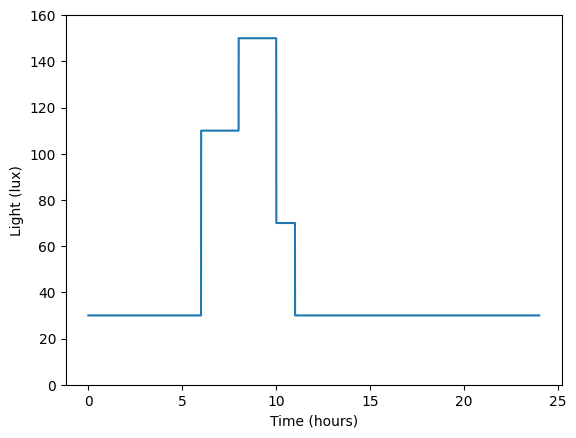

In [ ]:
#| hide
sum_schedule_2 = Light(100.0, start_time=6.0, duration=4.0, default_value=20.0) + Light(50.0, start_time=8.0, duration=3.0, default_value=10.0)
ax = sum_schedule_2.plot(0.0, 24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(0, 160);

In [ ]:
#| export
@patch_to(Light)
def RegularLight(lux: float=150.0, # lux intensity of the light
                 lights_on: float=8.0, # hour of the day for lights to come on
                 lights_off: float=16.0, # hour of the day for lights to go off
                 ) -> 'Light':
    "Create a light function that is on from `lights_on` to `lights_off` on a 24 hour schedule"
    # type checking
    if not isinstance(lux, (float, int)):
        raise ValueError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(lights_on, (float, int)):
        raise ValueError(f"lights_on must be a float or int, got {type(lights_on)}")
    if not isinstance(lights_off, (float, int)):
        raise ValueError(f"lights_off must be a float or int, got {type(lights_off)}")

    lights_on = np.mod(lights_on, 24.0)
    lights_off = np.mod(lights_off, 24.0)
    if lights_off > lights_on:
        end_time = lights_on + (lights_off - lights_on) 
        dark_section_before = Light(0.0, start_time=0.0, duration=lights_on)
        light_section = Light(lux, 
                        start_time=lights_on, 
                        duration=lights_off - lights_on)
        dark_section = Light(0.0, end_time, duration=24.0 - end_time)
        return dark_section_before.concatenate(light_section).concatenate(dark_section)
    else:
        first_light = Light(lux, start_time = 0.0, duration=lights_off)
        dark_section = Light(0.0, start_time=lights_off, duration=lights_on - lights_off)
        second_light = Light(lux, start_time=lights_on, duration=24.0 - lights_on)
        return  first_light.concatenate(dark_section).concatenate(second_light)

In [ ]:
#| hide
# Tests: RegularLight type checking
test_fail(lambda: Light.RegularLight(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.RegularLight(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.RegularLight(lights_on="a"), contains="lights_on must be a float or int")
test_fail(lambda: Light.RegularLight(lights_off="a"), contains="lights_off must be a float or int")

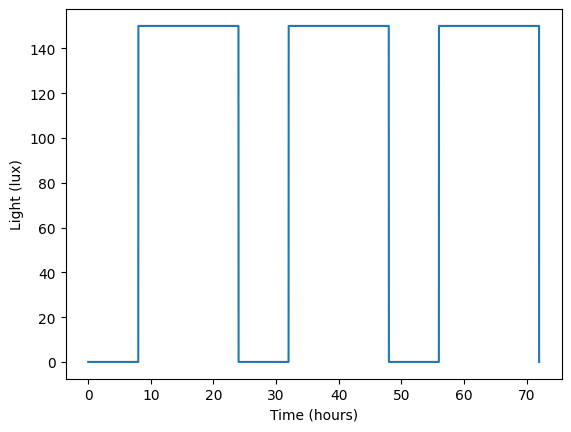

In [ ]:
#| hide
schedule = Light.RegularLight(lux=150.0, lights_on=8.0, lights_off=0.0)
ax = schedule.plot(0.0, 72.0, repeat_period=24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

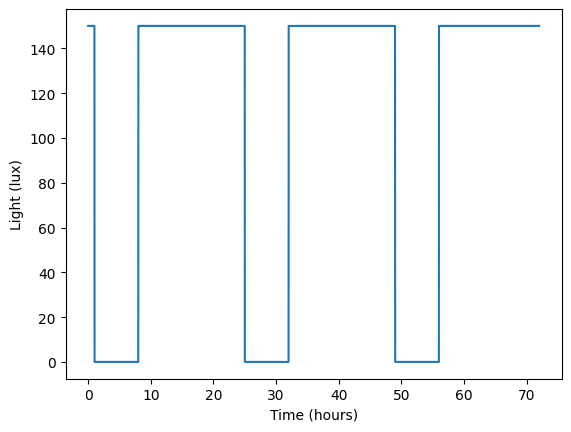

In [ ]:
#| hide
schedule = Light.RegularLight(lights_on=8.0, lights_off=1.0)
ax = schedule.plot(0.0, 72.0, repeat_period=24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

In [ ]:
#| export
@patch_to(Light)
def ShiftWorkLight(lux: float = 150.0, # lux intensity of the light
                   dayson: int = 3, # number of days on the night shift
                   daysoff: int = 2 # number of days off shift
                   ) -> 'Light':
    "Create a light schedule for a shift worker" 
    # type checking
    if not isinstance(lux, (float, int)):
        raise ValueError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(dayson, int):
        raise ValueError(f"dayson must be a nonnegative int, got {type(dayson)}")
    elif dayson < 0:
        raise ValueError(f"dayson must be a nonnegative int, got {dayson}")
    if not isinstance(daysoff, int):
        raise ValueError(f"daysoff must be a nonnegative int, got {type(daysoff)}")
    elif daysoff < 0:
        raise ValueError(f"daysoff must be a nonnegative int, got {daysoff}")
    if dayson == 0 and daysoff == 0:
        raise ValueError("dayson and daysoff cannot both be 0")
    
    workday = Light.RegularLight(lux=lux, lights_on=19.0, lights_off=11.0)
    offday = Light.RegularLight(lux=lux, lights_on=7.0, lights_off=23.0)
    total_schedule = [workday for _ in range(dayson-1)] + [offday for _ in range(daysoff)]
    for day in total_schedule:
        workday = workday.concatenate(day)
    return workday

In [ ]:
#| hide
# Tests: ShiftWorkLight type checking
test_fail(lambda: Light.ShiftWorkLight(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.ShiftWorkLight(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.ShiftWorkLight(dayson="a"), contains="dayson must be a nonnegative int")
test_fail(lambda: Light.ShiftWorkLight(dayson=-1), contains="dayson must be a nonnegative int")
test_fail(lambda: Light.ShiftWorkLight(daysoff="a"), contains="daysoff must be a nonnegative int")
test_fail(lambda: Light.ShiftWorkLight(daysoff=-1), contains="daysoff must be a nonnegative int")
test_fail(lambda: Light.ShiftWorkLight(dayson=0, daysoff=0), contains="dayson and daysoff cannot both be 0")

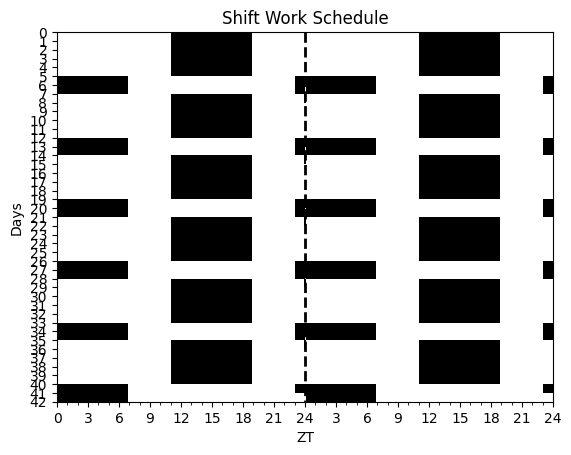

In [ ]:
#| hide
sw_light = Light.ShiftWorkLight(dayson=5, daysoff=2)
ts = np.arange(0, 24*7*6, 0.10)
light_values = sw_light(ts, repeat_period=24*7)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Shift Work Schedule");

In [ ]:
#| export
@patch_to(Light)
def SlamShift(lux: float = 150.0, # lux intensity of the light
              shift: float=8.0, # number of hours to shift the light schedule
              before_days: int=10, #number of days before the shift occurs 
              after_days: int=10, # number of days after the shift occurs
              starting_lights_on: float=8.0 # hour of the day for lights to come on
              ) -> 'Light':
    "Create a light schedule for a shift worker under a slam shift" 
    # type checking
    if not isinstance(lux, (float, int)):
        raise ValueError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(shift, (float, int)):
        raise ValueError(f"shift must be a nonnegative float or int, got {type(shift)}")
    elif shift < 0.0:
        raise ValueError(f"shift must be a nonnegative float or int, got {shift}")
    if not isinstance(before_days, int):
        raise ValueError(f"before_days must be a nonnegative int, got {type(before_days)}")
    elif before_days < 0:
        raise ValueError(f"before_days must be a nonnegative int, got {before_days}")
    if not isinstance(after_days, int):
        raise ValueError(f"after_days must be a nonnegative int, got {type(after_days)}")
    elif after_days < 0:
        raise ValueError(f"after_days must be a nonnegative int, got {after_days}")
    if not isinstance(starting_lights_on, (float, int)):
        raise ValueError(f"starting_lights_on must be a nonnegative float or int, got {type(starting_lights_on)}")
    elif starting_lights_on < 0.0:
        raise ValueError(f"starting_lights_on must be a nonnegative float or int, got {starting_lights_on}")

    light_before = Light.RegularLight(lux=lux, 
                                        lights_on=starting_lights_on, 
                                        lights_off= np.fmod(starting_lights_on + 16.0, 24.0)
                                        )
    light_after = Light.RegularLight(lux=lux, 
                                        lights_on=np.fmod(starting_lights_on+shift, 24.0), 
                                        lights_off=np.fmod(starting_lights_on+shift+16.0, 24.0)
                                        )
    total_schedule = [light_before for _ in range(before_days-1)] + [light_after for _ in range(after_days)]
    for day in total_schedule:
        light_before = light_before.concatenate(day)
    return light_before

In [ ]:
#| hide
# Tests: SlamShift type checking
test_fail(lambda: Light.SlamShift(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.SlamShift(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.SlamShift(shift="a"), contains="shift must be a nonnegative float or int")
test_fail(lambda: Light.SlamShift(shift=-1.0), contains="shift must be a nonnegative float or int")
test_fail(lambda: Light.SlamShift(before_days="a"), contains="before_days must be a nonnegative int")
test_fail(lambda: Light.SlamShift(before_days=-1), contains="before_days must be a nonnegative int")
test_fail(lambda: Light.SlamShift(after_days="a"), contains="after_days must be a nonnegative int")
test_fail(lambda: Light.SlamShift(after_days=-1), contains="after_days must be a nonnegative int")
test_fail(lambda: Light.SlamShift(starting_lights_on="a"), contains="starting_lights_on must be a nonnegative float or int")
test_fail(lambda: Light.SlamShift(starting_lights_on=-1.0), contains="starting_lights_on must be a nonnegative float or int")

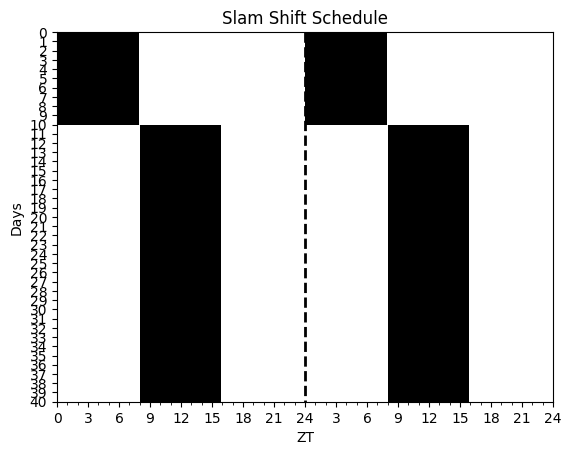

In [ ]:
#| hide
slam_shift = Light.SlamShift(shift=8.0,
                             before_days=10, 
                             after_days=40)
ts = np.arange(0, 24*40, 0.10)
light_values = slam_shift(ts)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Slam Shift Schedule");

In [ ]:
#| export
@patch_to(Light)
def SocialJetlag(lux: float = 150.0, # lux intensity of the light
                 num_regular_days: int = 5, # number of days with a regular schedule
                 num_jetlag_days: int = 2, # number of days with a delayed schedule
                 hours_delayed: float = 2.0, # number of hours to delay the schedule on the jetlag days
                 regular_days_lights_on: float=7.0, # hour of the day for lights to come on
                 ) -> 'Light':
    "Create a light schedule that simulates the effects of jetlag"
    # type checking
    if not isinstance(lux, (float, int)):
        raise ValueError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(num_regular_days, int):
        raise ValueError(f"num_regular_days must be a nonnegative int, got {type(num_regular_days)}")
    elif num_regular_days < 0:
        raise ValueError(f"num_regular_days must be a nonnegative int, got {num_regular_days}")
    if not isinstance(num_jetlag_days, int):
        raise ValueError(f"num_jetlag_days must be a nonnegative int, got {type(num_jetlag_days)}")
    elif num_jetlag_days < 0:
        raise ValueError(f"num_jetlag_days must be a nonnegative int, got {num_jetlag_days}")
    if not isinstance(hours_delayed, (float, int)):
        raise ValueError(f"hours_delayed must be a nonnegative float or int, got {type(hours_delayed)}")
    elif hours_delayed < 0.0:
        raise ValueError(f"hours_delayed must be a nonnegative float or int, got {hours_delayed}")
    if not isinstance(regular_days_lights_on, (float, int)):
        raise ValueError(f"regular_days_lights_on must be a nonnegative float or int, got {type(regular_days_lights_on)}")
    elif regular_days_lights_on < 0.0:
        raise ValueError(f"regular_days_lights_on must be a nonnegative float or int, got {regular_days_lights_on}")

    jetlag_day_lights_on = (regular_days_lights_on + hours_delayed) 
    jetlag_day_lights_off = (regular_days_lights_on+ 16.0 + hours_delayed) 
    regular_days = Light.RegularLight(lux=lux, lights_on=regular_days_lights_on, lights_off=regular_days_lights_on+16.0)
    jetlag_day = Light.RegularLight(lux=lux, lights_on=jetlag_day_lights_on, lights_off=jetlag_day_lights_on + 16.0)
    total_schedule = [regular_days for _ in range(num_regular_days-1)] + [jetlag_day for _ in range(num_jetlag_days)]
    for day in total_schedule:
        regular_days = regular_days.concatenate(day)
        
    return regular_days

In [ ]:
#| hide
# Tests: SocialJetlag type checking
test_fail(lambda: Light.SocialJetlag(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.SocialJetlag(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: Light.SocialJetlag(num_regular_days="a"), contains="num_regular_days must be a nonnegative int")
test_fail(lambda: Light.SocialJetlag(num_regular_days=-1), contains="num_regular_days must be a nonnegative int")
test_fail(lambda: Light.SocialJetlag(num_jetlag_days="a"), contains="num_jetlag_days must be a nonnegative int")
test_fail(lambda: Light.SocialJetlag(num_jetlag_days=-1), contains="num_jetlag_days must be a nonnegative int")
test_fail(lambda: Light.SocialJetlag(hours_delayed="a"), contains="hours_delayed must be a nonnegative float or int")
test_fail(lambda: Light.SocialJetlag(hours_delayed=-1.0), contains="hours_delayed must be a nonnegative float or int")
test_fail(lambda: Light.SocialJetlag(regular_days_lights_on="a"), contains="regular_days_lights_on must be a nonnegative float or int")
test_fail(lambda: Light.SocialJetlag(regular_days_lights_on=-1.0), contains="regular_days_lights_on must be a nonnegative float or int")

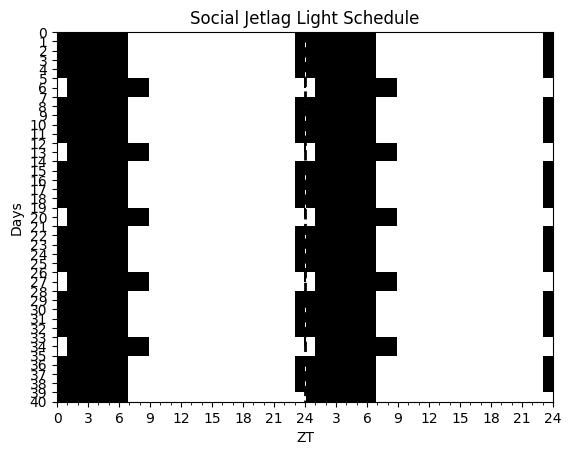

In [ ]:
#| hide
social_jl = Light.SocialJetlag()
ts = np.arange(0, 24*40, 0.10)
light_values = social_jl(ts, repeat_period=24*7)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Social Jetlag Light Schedule");

In [ ]:
#| export
def make_pulse(t, tstart, tend, steep: float = 30.0):
    return 0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-tend))

def get_pulse(t: float,
              t1: float,
              t2: float,
              repeat=False,
              Intensity: float = 150.0):

    if repeat:
        t = np.fmod(t, 24.0)
    if t < 0.0:
        t += 24.0

    light_value = Intensity*make_pulse(t, t1, t2)
    return np.abs(light_value)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()